# 2. Data Processing

In this notebook we will do:
- **Instrument response correction**;
- **Rotate data to the "great circle path"**;
- **Save the processed waveforms as SAC files**.

**Instrument response correction**: Remove the effects due to instrument responses that alter the seismograms.

**Rotate**: 
The original seismograms are in Vertical-North-East (ZNE) components. We need to rotate them to Vertical-Radial-Tangential (ZRT) components.

<img src="materials/zne.png" style="height: 200px;"/> <img src="materials/zrt.png" style="height: 300px; "/>

**Notes:**
 Here we use `ObsPy` for processing data, the goal here is to illustrate the general processing steps for waveform inversion. You can use whatever software of your choice to process your data (e.g. `SAC`). We always recommend to save a copy of the raw uncorrected data and a copy of the instrument corrected data. This is important for reproducibility and quality control.

In [1]:
# Import third-party libraries
from pathlib import Path
import pandas as pd
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.util.attribdict import AttribDict
import matplotlib.pyplot as plt

In [2]:
# 2.1 Define some parameters.
infile = "datetime.csv" # this file was generated in #1.2
df = pd.read_csv(infile,parse_dates=True)
pre_filt = (0.004,0.007,10,20) # Data processing parameters
outfile_name = "station.csv"

In [3]:
# 2.2 Lets start data processing

# We will go through the events in the Pandas table,
# if your table contains multiple events it will process all of them.

for index,row in df.iterrows():
    event_dir = row.evid
    
    # Make an output directory
    outdir = "%s/sac"%event_dir
    Path(outdir).mkdir(parents=True,exist_ok=True)
    
    # save origin info to event directory
    df[index:index+1].to_csv("%s/%s"%(event_dir,"datetime.csv"),index=False)
    
    # start processing
    
    ## Read response files
    inv = read_inventory("%s/stations/*"%event_dir,format='STATIONXML')
    
    ## Read data
    st = read("%s/waveforms/*"%event_dir,format='MSEED')
    
    ## Detrend and remove instrument response
    st.detrend(type="linear") # equivalent to rtr in SAC
    st.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP", zero_mean=True) # correct to displacement
    st.detrend(type="linear")
    st.detrend(type="demean") # remove mean

    ## Define SAC headers and calculate back-azimtuh for rotation
    origin_time = UTCDateTime(row.origin)
    depth = row.depth*1000
    for tr in st:
        meta = inv.get_channel_metadata(tr.id)
        dist, az, baz = gps2dist_azimuth(row.lat,row.lon,meta['latitude'],meta['longitude'])
        omarker = origin_time - tr.stats.starttime

        ### Obspy trace headers
        #tr.stats.coordinates = {'latitude':meta['latitude'], 'longitude':meta['longitude']}
        tr.stats.distance = dist
        tr.stats.back_azimuth = baz
        ### SAC headers
        sacd = AttribDict()
        sacd.stla = meta['latitude']
        sacd.stlo = meta['longitude']
        sacd.stel = meta['elevation']
        sacd.evla = row.lat
        sacd.evlo = row.lon
        sacd.evdp = depth # in meters
        sacd.az = az
        sacd.baz = baz
        sacd.dist = dist/1000 # convert to kilometers
        sacd.o = 0
        sacd.b = -1*omarker
        tr.stats.sac = sacd

    ## Rotate to ZNE
    st._rotate_to_zne(inv,components=("ZNE","Z12"))

    ## Get station names
    netstaloccha = sorted(set(
            [(tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel[:-1]) for tr in st]
            ))
    
    ## Keep only three-component seismograms, then rotate horizontals to RT
    for net, sta, loc, cha in netstaloccha:
        traces = st.select(network=net,station=sta,location=loc,channel="%s[ZNE]"%cha)
        if len(traces) != 3:
            for tr in traces:
                st.remove(tr)
        else:
            traces.rotate(method="NE->RT")
    
    ## Update station names
    netstaloccha = set(
        [(tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel[:-1], "ZRT",
          tr.stats.sac.dist, tr.stats.sac.az, tr.stats.sac.stlo, tr.stats.sac.stla) for tr in st.select(component="Z")]
        )
    
    ## Save station information to a Pandas table
    header = ("network","station","location","channel","component","distance","azimuth","longitude","latitude")
    df2 = pd.DataFrame(netstaloccha, columns=header)
    df2 = df2.sort_values("distance")
    df2.to_csv("%s/%s"%(event_dir,outfile_name),index=False)
    
    ## Save the data in SAC format
    print("Saving instrument corrected data to %s."%outdir)
    for tr in st:
        tr.write("%s/%s"%(outdir,tr.id),format="SAC")    
    

Saving instrument corrected data to 41423391/sac.


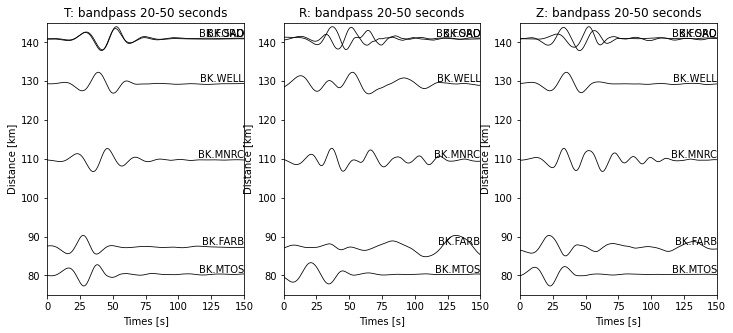

In [4]:
# 2.3 Plot seismograms

#  Let's take a look at the waveforms to determine the period band
#  for moment tensor inversion. Regional earthquakes tend to have
#  good signals in the intermediate period band (20-50 seconds).
#  We will apply the filter on a copy of the original seismograms.
#  The period will be used in next section for producing synthetic waveforms. 


# The frequency range for the filter
freqmin = 0.02
freqmax = 0.05
corners = 2
st_filt = st.copy() # copy the seismograms

# Apply filter and taper the edges
st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
st_filt.taper(max_percentage=0.05)

# Each seismogram is normalized against each trace
xmin = 0
xmax = 150
ymin = 75
ymax = 145
scale = 3 # scale the traces
fig, axes = plt.subplots(1,3,figsize=(12,5))
for component, ax in zip(("T","R","Z"),axes):
    for tr in st_filt.select(component=component):
        times = tr.times() - (origin_time - tr.stats.starttime)
        tr.data /= max(abs(tr.data))
        tr.data *= scale
        ax.plot(times,tr.data+tr.stats.sac.dist,color="black",linewidth=0.8)
        ax.text(xmax,tr.stats.sac.dist,"%s.%s"%(tr.stats.network,tr.stats.station),va="bottom",ha="right")
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel("Times [s]")
    ax.set_ylabel("Distance [km]")
    ax.set_title("%s: bandpass %.0f-%.0f seconds"%(component, 1/freqmax, 1/freqmin) )

# **Now, let's move on to the next notebook on data and synthetics.**
